In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
class SmallHall:
    def __init__(self):
        self.pos = 0

    def reset(self):
        self.pos = 0
        return None

    def move(self, action):
        table = [-1, 1]
        if self.pos == 0 or self.pos == 2:
            self.pos += table[action]
        else:
            self.pos -= table[action]
        
        if self.pos < 0:
            self.pos = 0

        if self.pos == 3:
            return None, 0, True
        else:
            return None, -1, False

In [64]:
class REINFORCEwithBaseline:
    def __init__(self, alpha, do=False):
        self.alpha_theta = alpha
        self.alpha_w = 2**-8
        self.gamma = 0.95
        self.theta = np.array([2.5, 0])
        self.w = np.zeros(2)

        if do:
            self.do()

    def do(self):
        env = SmallHall()
        x = np.array([[1, 0], [0, 1]])

        self.steps = []
        self.thetas = []
        self.ws = []

        for epi in range(1000):
            env.reset()
            done = False

            actions = []
            rewards = []

            for step in range(50000):
                h = np.dot(self.theta, x)
                h -= np.max(h)
                prob = np.exp(h) / np.sum(np.exp(h))

                action = np.random.choice([0, 1], p=prob)
                _, reward, done = env.move(action)

                actions.append(action)
                rewards.append(reward)

                if done:
                    break

            h = np.dot(self.theta, x)
            h -= np.max(h)
            
            grad1 = np.exp(h) / np.sum(np.exp(h))
            grad1[1] *= -1

            grad2 = np.exp(h) / np.sum(np.exp(h))
            grad2[0] *= -1

            grad = [grad1, grad1]

            new_w = self.w.copy()
            for i, reward in enumerate(rewards):
                G = sum([self.gamma ** (j - i) * rewards[j] for j in range(i, len(rewards))])
                delta = G - np.dot(self.w, x[actions[i]])
                new_w += self.alpha_w * delta * x[actions[i]]
                self.theta += self.alpha_theta * self.gamma ** i * delta * grad[actions[i]]
            
            self.w = new_w
            self.steps.append(step)
            self.thetas.append(self.theta.copy())
            self.ws.append(self.w.copy())

In [79]:
trial = 100

t1 = [REINFORCEwithBaseline(2**-11, do=True) for _ in range(trial)]
steps1 = [t1[i].steps for i in range(trial)]
theta1 = [t1[i].thetas for i in range(trial)]
w1 = [t1[i].ws for i in range(trial)]

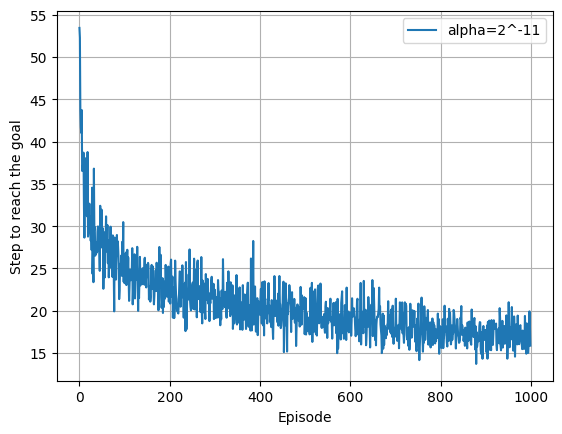

In [80]:
plt.plot(np.mean(steps1, axis=0), label='alpha=2^-11')

plt.xlabel('Episode')
plt.ylabel('Step to reach the goal')
plt.legend()
plt.grid()
plt.show()

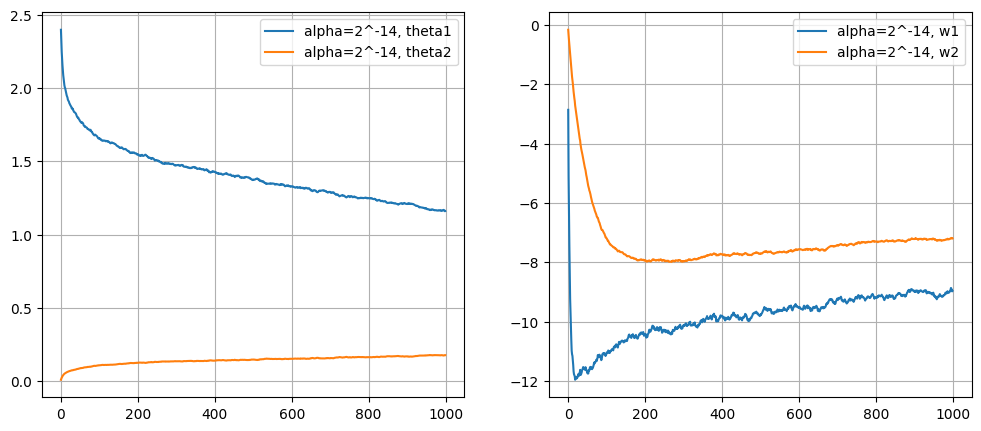

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(np.mean(theta1, axis=0)[:, 0], label='alpha=2^-14, theta1')
ax[0].plot(np.mean(theta1, axis=0)[:, 1], label='alpha=2^-14, theta2')

ax[1].plot(np.mean(w1, axis=0)[:, 0], label='alpha=2^-14, w1')
ax[1].plot(np.mean(w1, axis=0)[:, 1], label='alpha=2^-14, w2')

for i in range(2):
    ax[i].legend()
    ax[i].grid()
    # ax[i].set_ylim(-1, 2.5)
